<h2 align=center> Facial Expression Recognition</h2>

## Importing Libraries

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf

## Getting total number of images of each category

In [10]:
for expression in os.listdir("dataset/train/"):
    print(str(len(os.listdir("dataset/train/" + expression))) + " " + expression + " images")

7215 happy images
4830 sad images
4097 fear images
3171 surprise images
4965 neutral images
3995 angry images
436 disgust images


## Generate Training and Validation Batches

In [11]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("dataset/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("dataset/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Create CNN Model

In [12]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_5 (Batc  (None, 24, 24, 128)     

## Training and Evaluating Model

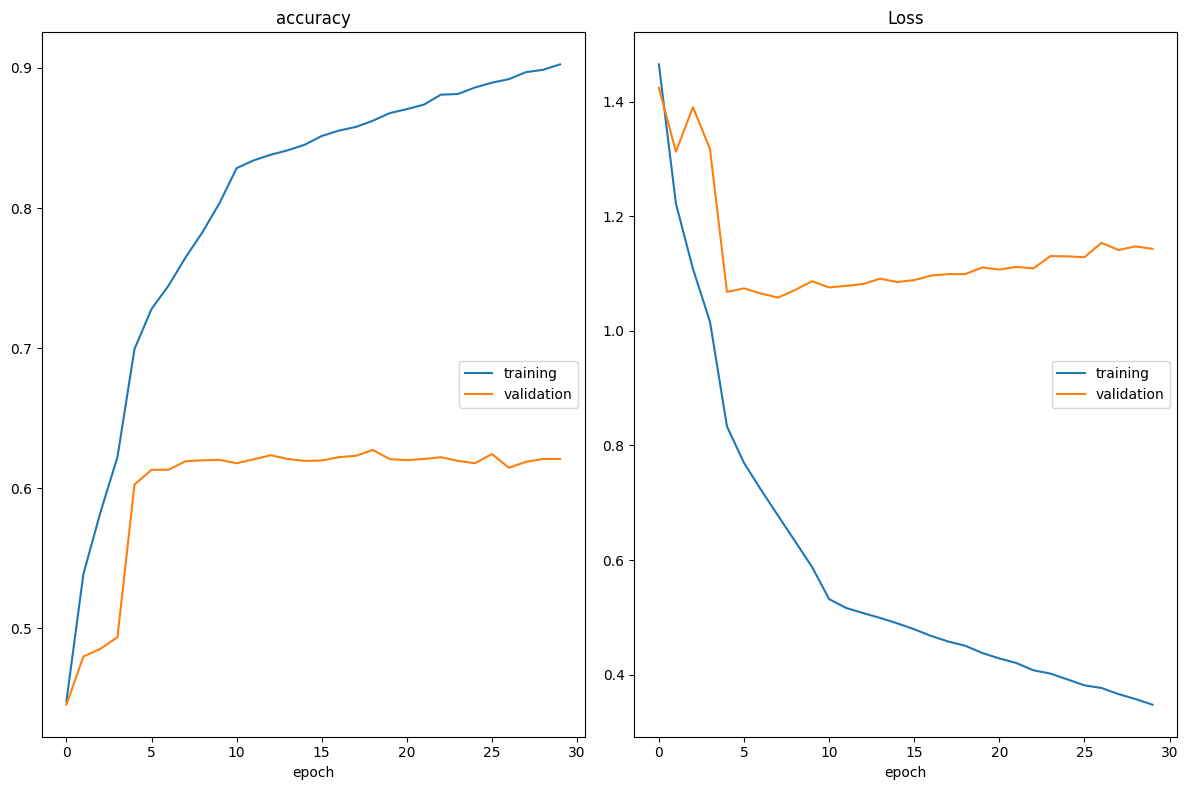

accuracy
	training         	 (min:    0.448, max:    0.903, cur:    0.903)
	validation       	 (min:    0.445, max:    0.627, cur:    0.621)
Loss
	training         	 (min:    0.348, max:    1.465, cur:    0.348)
	validation       	 (min:    1.058, max:    1.424, cur:    1.143)

Epoch 30: saving model to small_model_weights.h5
448/448 [==============================] - 21s 48ms/step - loss: 0.3477 - accuracy: 0.9026 - val_loss: 1.1431 - val_accuracy: 0.6208 - lr: 1.0000e-05
CPU times: user 5min 16s, sys: 2min 15s, total: 7min 32s
Wall time: 27min 6s


In [13]:
%%time

epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("models/emotion_model_small.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

## Represent Model as JSON String

In [14]:
model_json = model.to_json()
with open("models/emotion_model_small.json", "w") as json_file:
    json_file.write(model_json)